# M-sigma relation
In this hand-on example, we are going to use two different techniques to determine the best fit parameters and their associated errors for the famous M-sigma relation. This relation maps an easily observable quantity, the velocity dispersion of a galaxy, to a non-observable -- the mass of the galaxy's central supermassive black hole. We are going to be using two methodologies: 1) a classic linear regression approach and 2) a Bayesian inference approach. Throughout this notebook, you will be exploring how we go about applying these techniques and what they mean for our analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplcyberpunk
import emcee
import corner
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

plt.style.use("cyberpunk")

# Part 1: Familiarization with the data
In this section, we are going to familiarize ourselves with the data. This portion will be so that we can all have a base line understanding of the data.

We are going to be using data from the [2009 paper](https://arxiv.org/pdf/0903.4897.pdf) entitled: THE M–σ AND M–L RELATIONS IN GALACTIC BULGES, AND DETERMINATIONS OF THEIR INTRINSIC SCATTER. In this paper, the authors fit a functional form of the relationship between the mass of the supermassive black hole and the velocity dispersion of stars in galaxies. The functional form is the following:

$$ 
\log(M_{\text{BH}}/M_\odot) = \alpha + \beta  \log(\sigma)
$$


If, however, we simply take this equation, we can ask ourselves what values of $\alpha$ and $\beta$ best fit the data? Also, we can determine the errors on these values. Let's take a look at the data which was taken directly from the paper.

In [2]:
data = pd.read_csv('M-Sigma-Table.txt', delimiter=' ')
data['M_BH'] = np.log10(data['M_BH'])
data['M_low'] = np.log10(data['M_low'])
data['M_high'] = np.log10(data['M_high'])
# Change low and high to errors
data['M_low'] = data['M_BH']-data['M_low']
data['M_high'] = data['M_high']-data['M_BH']


So we see that we have fifty galaxies in our sample. All masses are quoted in terms of solar masses ($M_\odot$), all dispersions in terms of $km/s$, and all distances in kiloparsecs. What does this look like if we plot the masses vs the dispersions including errors?

<ErrorbarContainer object of 3 artists>

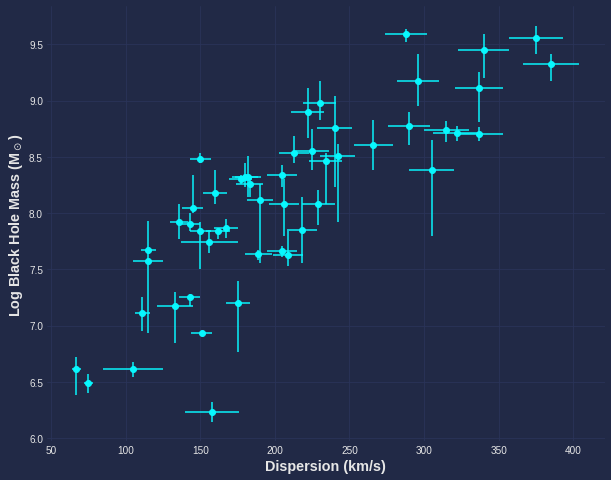

In [3]:
fig = plt.figure(figsize=(10,8))
plt.xlabel('Dispersion (km/s)', fontsize='x-large', fontweight='bold')
plt.ylabel(r'Log Black Hole Mass (M$_\odot$)', fontsize='x-large', fontweight='bold')
plt.errorbar(data['sigma'], data['M_BH'], xerr=data['sigma_error'], yerr=[data['M_low'], data['M_high']], fmt='o')

# Part 2: Data Analysis
In this section, we will explore how to use linear regression and bayesian inference to set estimates with errors on the parameters governing the M-sigma relation

In [4]:
# Functional form of our equation -- we will use this in the Bayesian section
def M_sigma(sigma, alpha, beta):
    """
    log(𝑀BH/𝑀⊙)=𝛼+𝛽log(𝜎/200𝑘𝑚𝑠−1)
    """
    return alpha+beta*np.log10(sigma)

## Part 2.1: Linear Regression
In this example, we are going to assume that our cost function is the *mean square error* (MSE) which has the following form:
$$
C(\theta) = \frac{1}{m}\sum_{i=1}^m (f_{\theta}(x)-y)^2
$$
where $f_{\theta}(x)$ is the assumed functional form of the relationship between $x$ and $y$ evaluated for some values of $\theta$ where $\theta$ represents our set of variables. $m$ is the number of data points in our sample.

We will be using the *scikit-learn* implementation called by **mean_squared_error**.

Since you have already seen the theory of linear regression, we will simply be using a commonly-used implementation of linear regression that is present in *sklearn*.

In [5]:
# Step 1: Initialize the model
model = LinearRegression()
# Step 2: Fit! (Note we have to reshape the X parameter to have the correct shape)
model.fit(np.log10(data['sigma']).to_numpy().reshape((-1, 1)), data['M_BH'].to_numpy())

LinearRegression()

Let's see how well we did! We can take a look at the reduced chi-squared value which is hopefully near-ish to one. We can then plot our line of best fit and see how it worked!

In [7]:
r_sq = model.score(np.log10(data['sigma']).to_numpy().reshape((-1, 1)), data['M_BH'].to_numpy())
print(f"coefficient of determination: {r_sq}")
print(r'$\alpha$:%.2E'%model.intercept_) 
print(r'$\beta$:%.2E'%model.coef_) 

coefficient of determination: 0.698146674681597
$\alpha$:-8.20E-01
$\beta$:3.91E+00


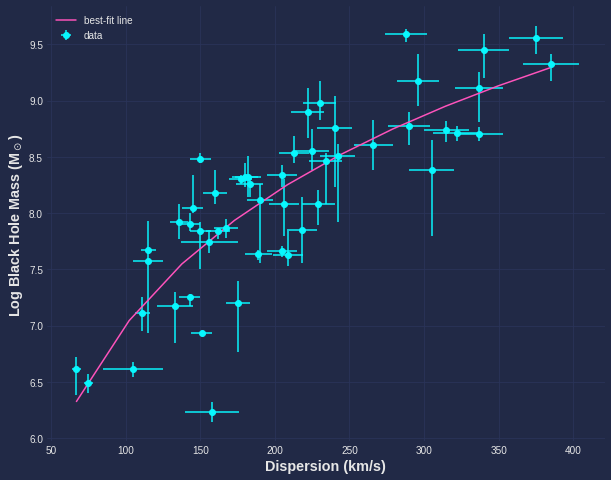

In [9]:
sigma_plot_values = np.linspace(data['sigma'].min(), data['sigma'].max(), 10)

fig = plt.figure(figsize=(10,8))
plt.xlabel('Dispersion (km/s)', fontsize='x-large', fontweight='bold')
plt.ylabel(r'Log Black Hole Mass (M$_\odot$)', fontsize='x-large', fontweight='bold')
plt.errorbar(data['sigma'], data['M_BH'], xerr=data['sigma_error'], yerr=[data['M_low'], data['M_high']], fmt='o', label='data')
plt.plot(sigma_plot_values, M_sigma(sigma_plot_values, model.intercept_, model.coef_), label='best-fit line')
plt.legend()

#### Great!!! So we can see that our analysis did a pretty decent job but note that we didn't take errors into account! We will do this using Bayesian Inference via the package *emcee*.

## Part 2.2: Bayesian Analysis
In order to run the Bayesian analysis, we need to define our likelihood and our prior functions. Let's get down to it!

In [15]:
# Likelihood function
def log_likelihood(theta, x, y, yerr):
    alpha, beta = theta  # Get variables
    model = beta*np.log10(x) + alpha#M_sigma(x, alpha, beta)  # Calculate Model
    sigma2 = (yerr)**2   # Calculate errors
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))  # Calculate log likelihood assuming Gaussian likelihood function

As for the priors, we are going to assume non-informative priors over a reasonable range of values

In [16]:
def log_prior(theta):
    alpha, beta = theta
    if -10.0 < alpha < 10.0 and -10.0 < beta < 10.0:
        return 0.0
    return -np.inf

Now we can put it all together by using a 'probability' function -- this is somewhat particular to *emcee*

In [17]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

Finally, we can define our initial values and walk! We are going to take our solution from a standard linear regression as our initial guesses

In [18]:
pos = np.array([model.coef_[0], model.intercept_]) + 1e-2 * np.random.randn(32, 2)  # Add a bit of random noisr
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(data['sigma'], data['M_BH'], np.max(data['M_high']-data['M_low']))
)
sampler.run_mcmc(pos, 1000, progress=True);

100%|██████████| 1000/1000 [00:13<00:00, 74.78it/s]


*Emcee* allows us to visualize the chains easily

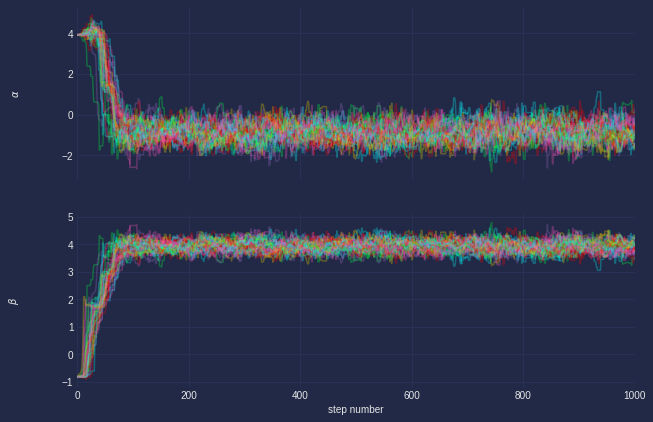

In [19]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = [r"$\alpha$", r"$\beta$"]
for i in range(2):
    ax = axes[i]
    ax.plot(samples[:, :, i], alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [24]:
# We now flatten them so that we can caluclate the median values and the errors
flat_samples = sampler.get_chain(discard=100,  flat=True)  # Discard first 100 steps

In [26]:
alpha_median = np.median(flat_samples[:,0])
beta_median = np.median(flat_samples[:,1])
print(r"The mean values of $\alpha$ and $\beta$ are %.2f and %.2f"%(alpha_median, beta_median))
alpha_std = np.std(flat_samples[:,0])
beta_std = np.std(flat_samples[:,1])
print(r"The 1-sigma values of $\alpha$ and $\beta$ are %.2f and %.2f"%(alpha_std, beta_std))


The mean values of $\alpha$ and $\beta$ are -0.87 and 3.93
The 1-sigma values of $\alpha$ and $\beta$ are 0.48 and 0.21


Additionally we can use the corner package to see the posterior functions. We will overplot the true values in blue.

/home/carterrhea/miniconda3/envs/astro/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


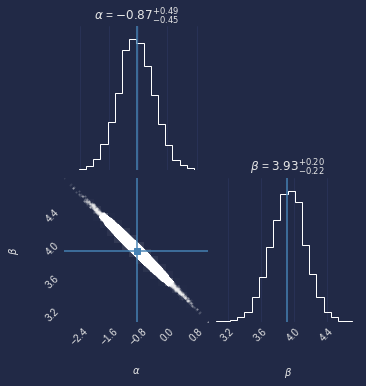

In [28]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[model.intercept_, model.coef_], color='w', show_titles=True, title_kwargs={"fontsize": 12}
);

## Results
Awesome! Let's see how this looks in our M-$\sigma$ plot.

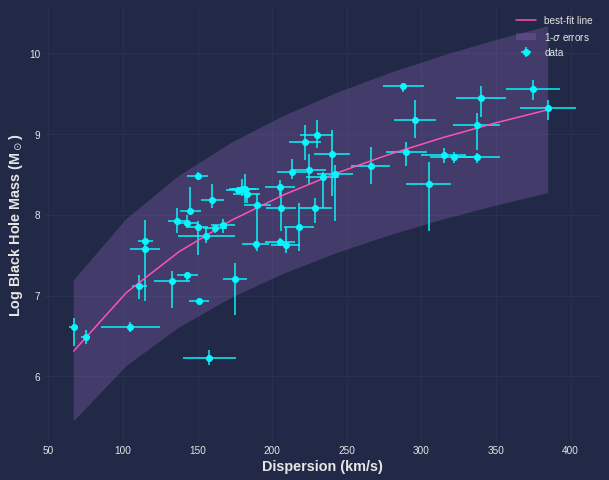

In [37]:
fitted_line = M_sigma(sigma_plot_values, alpha_median, beta_median)
fitted_line_low = M_sigma(sigma_plot_values, alpha_median-alpha_std, beta_median-beta_std)
fitted_line_high = M_sigma(sigma_plot_values, alpha_median+alpha_std, beta_median+beta_std)
fig = plt.figure(figsize=(10,8))
plt.xlabel('Dispersion (km/s)', fontsize='x-large', fontweight='bold')
plt.ylabel(r'Log Black Hole Mass (M$_\odot$)', fontsize='x-large', fontweight='bold')
plt.errorbar(data['sigma'], data['M_BH'], xerr=data['sigma_error'], yerr=[data['M_low'], data['M_high']], fmt='o', label='data')
plt.plot(sigma_plot_values, fitted_line, label='best-fit line')
plt.fill_between(sigma_plot_values, fitted_line_low, fitted_line_high, facecolor='C5', alpha=0.3, label=r'1-$\sigma$ errors')

plt.legend()

## 